## Modeling
### Experiments with XGBoost for Forecasting Stocks

**Objetivo**: O objetivo deste notebook é fazer experimentos de modelagem com o modelo XGBoost, que será construido de forma iterativa (1 step-ahead forecast)



**Conclusões**:


### 1.0 Imports

In [26]:
%pip install xgboost
%pip install statsmodels
%pip install mlflow
%pip install hyperopt

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [27]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import logging
from joblib import load, dump
#from pandas_profiling import ProfileReport

# Time Series Libraries
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  #Autocorrelação (MA), Autocorrelatcao parcial (AR)ve

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import xgboost as xgb
from hyperopt import fmin, tpe, Trials, hp, SparkTrials, space_eval, STATUS_OK, rand, Trials

from scipy.stats import shapiro, normaltest, kstest

import mlflow

### 2.0 Definindo Parâmetros

In [28]:
model_config = {
    "TEST_SIZE": 0.2,
    "TARGET_NAME": "Close",
    "VALIDATION_METRIC": "MAPE",
    "OPTIMIZATION_METRIC": "MSE",
    "FORECAST_HORIZON": 14,
    "REGISTER_MODEL_NAME": "Stock_Predictor"
}

features_list = ["day_of_month", "month", "quarter", "Close_lag_1"]
run_name = "Experiment_run"

# Define a ação para procurar
STOCK_NAME = 'BOVA11.SA'

In [29]:
xgboost_model_config = {
    'LEARNING_RATE': 0.01,
    'MAX_DEPTH': 100,
    'MIN_DATA': 100,
    'N_ESTIMATORS': 1000,
    'REG_LAMBDA': 100,
    'SCALE_POS_WEIGHT': 10,
    'SEED': 42,
    'SUBSAMPLE': 0.9,
    'COLSAMPLE_BYTREE': 0.9,
    'NUM_BOOST_ROUNDS': 200,
    'GAMMA': 0.01
}

xgboost_fixed_model_config = {
    'SEED': 42,
    'SUBSAMPLE': 1.0
}
xgboost_hyperparameter_config = {
    'max_depth': hp.choice('max_depth', [4, 9, 11, 30]),
    'learning_rate': hp.choice('learning_rate', [0.01, 0.08 ,0.1, 0.5, 1.0]),
    'gamma': hp.choice('gamma', [0.01, 0.08, 0.1, 1.0]),
    'reg_lambda': hp.choice('reg_lambda', [1, 10, 30, 100]),
    'n_estimators': hp.choice('n_estimators', [40, 200, 300, 1000]),
    'scale_pos_weight': hp.choice('scale_pos_weight', [1, 2, 3, 4, 10, 15]),
    'colsample_bytree': hp.choice('colsample_bytree', [1.0]),
}

In [30]:
log_format = "[%(name)s][%(levelname)-6s] %(message)s"
logging.basicConfig(format=log_format)
logger = logging.getLogger("describe")
logger.setLevel(logging.DEBUG)

### 3.0 Criando Funções

In [31]:
def build_features(raw_df: pd.DataFrame, features_list: list) -> pd.DataFrame:
    """
    This function creates the features for the dataset to be consumed by the
    model
    
    :param raw_df: Raw Pandas DataFrame to create the features of
    :param features_list: The list of features to create

    :return: Pandas DataFrame with the new features
    """

    logger.info("Building the features...")

    stock_df_featurized = raw_df.copy()
    for feature in features_list:
        
        # create "Time" features
        if feature == "day_of_month":
            stock_df_featurized['day_of_month'] = stock_df_featurized["Date"].apply(lambda x: float(x.day))
        elif feature == "month":
            stock_df_featurized['month'] = stock_df_featurized['Date'].apply(lambda x: float(x.month))
        elif feature == "quarter":
            stock_df_featurized['quarter'] = stock_df_featurized['Date'].apply(lambda x: float(x.quarter))

    # Create "Lag" features
    # The lag 1 feature will become the main regressor, and the regular "Close" will become the target.
    # As we saw that the lag 1 holds the most aucorrelation, it is reasonable to use it as the main regressor.
        elif feature == "Close_lag_1":
            stock_df_featurized['Close_lag_1'] = stock_df_featurized['Close'].shift()


    # Drop nan values because of the shift
    stock_df_featurized = stock_df_featurized.dropna()

    # Save the dataset
    stock_df_featurized.to_csv("../data/processed/processed_stock_prices.csv", index=False)

    return stock_df_featurized

In [32]:
def ts_train_test_split(data: pd.DataFrame, target:str, test_size: int):
    """
    Splits the Pandas DataFrame into training and tests sets
    based on a Forecast Horizon value.

    Paramteres:
        data (pandas dataframe): Complete dataframe with full data
        targer (string): the target column name
        test_size (int): the amount of periods to forecast

    Returns:
        X_train, X_test, y_train, y_test dataframes for training and testing
    """

    logger.info("Spliting the dataset...")

    train_df = data.iloc[:-test_size, :]
    test_df = data.iloc[-test_size:, :]
    X_train = train_df.drop(target, axis=1)
    y_train = train_df[target]
    X_test = test_df.drop(target, axis=1)
    y_test = test_df[target]

    return X_train, X_test, y_train, y_test

In [33]:
def visualize_validation_results(pred_df: pd.DataFrame, model_mape: float, model_rmse: float):
    """
    Creates visualizations of the model validation

    Paramters:
        pred_df: DataFrame with true values, predictions and the date column
        model_mape: The validation MAPE
        model_rmse: The validation RMSE

    Returns:
        None
    """

    logger.info("Vizualizing the results...")

    fig, axs = plt.subplots(figsize=(12, 5))
    # Plot the Actuals
    sns.lineplot(
        data=pred_df,
        x="Date",
        y="Actual",
        label="Testing values",
        ax=axs
    )
    sns.scatterplot(
        data=pred_df,
        x="Date",
        y="Actual",
        ax=axs,
        size="Actual",
        sizes=(80, 80), legend=False
    )

    # Plot the Forecasts
    sns.lineplot(
        data=pred_df,
        x="Date",
        y="Forecast",
        label="Forecast values",
        ax=axs
    )
    sns.scatterplot(
        data=pred_df,
        x="Date",
        y="Forecast",
        ax=axs,
        size="Forecast",
        sizes=(80, 80), legend=False
    )

    axs.set_title(f"Default XGBoost {model_config['FORECAST_HORIZON']} days Forecast for {STOCK_NAME}\nMAPE: {round(model_mape*100, 2)}% | RMSE: R${model_rmse}")
    axs.set_xlabel("Date")
    axs.set_ylabel("R$")

    #plt.savefig(f"./reports/figures/XGBoost_predictions_{dt.datetime.now().date()}.png")
    plt.show()

In [34]:
def visualize_forecast(pred_df: pd.DataFrame, historical_df: pd.DataFrame, stock_name: str):
    """
    Creates visualizations of the model forecast

    Paramters:
        pred_df: DataFrame with true values, predictions and the date column
        historical_df: DataFrame with historical values

    Returns:
        None
    """

    logger.info("Vizualizing the results...")

    fig, axs = plt.subplots(figsize=(12, 5), dpi = 2000)
    # Plot the Actuals
    sns.lineplot(
        data=historical_df,
        x="Date",
        y="Close",
        label="Historical values",
        ax=axs
    )
    sns.scatterplot(
        data=historical_df,
        x="Date",
        y="Close",
        ax=axs,
        size="Close",
        sizes=(80, 80),
        legend=False
    )

    # Plot the Forecasts
    sns.lineplot(
        data=pred_df,
        x="Date",
        y="Forecast",
        label="Forecast values",
        ax=axs
    )
    sns.scatterplot(
        data=pred_df,
        x="Date",
        y="Forecast",
        ax=axs,
        size="Forecast",
        sizes=(80, 80),
        legend=False
    )

    axs.set_title(f"Default XGBoost {model_config['FORECAST_HORIZON']-4} days Forecast for {stock_name}")
    axs.set_xlabel("Date")
    axs.set_ylabel("R$")

    plt.show()
    return fig

In [36]:
def train_model(X_train, y_train, random_state=42):
    """
    Trains a XGBoost model for Forecasting
    
    :param X_train: Training Features
    :param y_train: Training Target

    :return: Fitted model
    """
    

    with mlflow.start_run(run_name=run_name) as run:
        # create the model
        xgboost_model = xgb.XGBRegressor(
            random_state=random_state,
            )

        # train the model
        xgboost_model.fit(
            X_train,
            y_train, 
            )

         # get the run id
        model_uri = f"runs:/{run.info.run_id}/{model_config['REGISTER_MODEL_NAME']}_{run_name}"

        # log the model
        model_signature = mlflow.models.signature.infer_signature(X_train, pd.DataFrame(y_train))

        mlflow.sklearn.log_model(
            xgboost_model,
            "first_xgboost",
            input_example=X_train.head(),
            signature=model_signature
        )

        # register the model
        model_details = mlflow.register_model(
            model_uri = model_uri,
            name = model_config['REGISTER_MODEL_NAME']
        )


        # set model to staging version to be tested
        client = mlflow.MlflowClient()

        client.transition_model_version_stage(
            name=model_config["REGISTER_MODEL_NAME"],
            version=model_details.version,
            stage="Staging"
        )


        
    return xgboost_model


In [50]:
def train_model(X_train: pd.DataFrame,  y_train: pd.DataFrame, random_state:int=42):
    """
    Trains a XGBoost model for Forecasting
    
    :param X_train: Training Features
    :param y_train: Training Target

    :return: Fitted model
    """
    logger.info("Training the model...")

    
    params = {'colsample_bytree': 1.0,
     'gamma': 0.01,
     'learning_rate': 1.0,
     'max_depth': 30,
     'n_estimators': 40,
     'reg_lambda': 10,
     'scale_pos_weight': 1
    }
    # create the model
    xgboost_model = xgb.XGBRegressor(
        random_state=random_state,
        **params
        )

    # train the model
    xgboost_model.fit(
        X_train,
        y_train,
        )

    # save model
    dump(xgboost_model, f"./{model_config['REGISTER_MODEL_NAME']}_nb.joblib")

    return xgboost_model

In [38]:
def validate_model(X:pd.DataFrame, y:pd.Series, forecast_horizon: int) -> pd.DataFrame:
    """
    Make predictions for the next `forecast_horizon` days using a XGBoost model.
    This function performs the validation on the last days using stepwise predictions:
    The model is trained every new day.
    
    Parameters:
        X (pandas dataframe): The input data
        y (pandas dataframe): The target data
        forecast_horizon (int): Number of days to forecast
        
    Returns:
        None
    """

    logger.info("Starting the pipeline..")


    # Create empty list for storing each prediction
    predictions = []
    actuals = []
    dates = []


    # Iterate over the dataset to perform predictions over the forecast horizon, one by one.
    # So we need to start at training = training until the total forecast horizon, then, perform the next step
    # After forecasting the next step, we need to append the new line to the training dataset and so on

    for day in range(forecast_horizon, 0, -1):

        # update the training and testing sets
        X_train = X.iloc[:-day, :]
        y_train = y.iloc[:-day]
 
        if day != 1:
            # the testing set will be the next day after the training
            X_test = X.iloc[-day:-day+1,:]
            y_test = y.iloc[-day:-day+1]

        else:
            # need to change the syntax for the last day (for -1:-2 will not work)
            X_test = X.iloc[-day:,:]
            y_test = y.iloc[-day:]


        # only the first iteration will use the true value of y_train
        # because the following ones will use the last predicted value as true value
        # so we simulate the process of predicting out-of-sample
        if len(predictions) != 0:
            # update the y_train with the last predictions
            y_train.iloc[-len(predictions):] = predictions[-len(predictions):]

            # now update the Close_lag_1 feature
            X_train.iloc[-len(predictions):, -1] = y_train.shift(1).iloc[-len(predictions):]
            X_train = X_train.dropna()

        else:
            pass
        
        
        # train the model
        xgboost_model = train_model(X_train.drop("Date", axis=1), y_train)

        # make prediction
        prediction = xgboost_model.predict(X_test.drop("Date", axis=1))

        # store the results
        predictions.append(prediction[0])
        actuals.append(y_test.values[0])
        dates.append(X_test["Date"].max())

    # Calculate the resulting metric
    model_mape = round(mean_absolute_percentage_error(actuals, predictions), 4)
    model_rmse = round(np.sqrt(mean_squared_error(actuals, predictions)), 2)
 
    pred_df = pd.DataFrame(list(zip(dates, actuals, predictions)), columns=["Date", 'Actual', 'Forecast'])
    pred_df["Forecast"] = pred_df["Forecast"].astype("float64")
    visualize_validation_results(pred_df, model_mape, model_rmse)
    
    return pred_df

In [39]:
def validade_model_one_shot(X:pd.DataFrame, y:pd.Series, forecast_horizon: int) -> pd.DataFrame:
    """
    Make predictions for the next `forecast_horizon` days using a XGBoost model.
    This model is validated using One Shot Training, it means that we train the model
    once, and them perform the `forecast_horizon` predictions only loading the mdoel.
    
    Parameters:
        X (pandas dataframe): The input data
        y (pandas dataframe): The target data
        forecast_horizon (int): Number of days to forecast
        
    Returns:
        pred_df: Pandas DataFrame with the forecasted values
    """

    logger.info("Starting the pipeline..")

    # Create empty list for storing each prediction
    predictions = []
    actuals = []
    dates = []
    
    # get the one-shot training set
    X_train = X.iloc[:-forecast_horizon, :]
    y_train = y.iloc[:-forecast_horizon]
    
    # train the model once
    xgboost_model = train_model(
        X_train.drop("Date", axis=1),
        y_train
    )

    # Iterate over the dataset to perform predictions over the forecast horizon, one by one.
    # After forecasting the next step, we need to update the "lag" features with the last forecasted
    # value
    for day in range(forecast_horizon-4, 0, -1):
        
        if day != 1:
            # the testing set will be the next day after the training and we use the complete dataset
            X_test = X.iloc[-day:-day+1,:]
            y_test = y.iloc[-day:-day+1]

        else:
            # need to change the syntax for the last day (for -1:-2 will not work)
            X_test = X.iloc[-day:,:]
            y_test = y.iloc[-day:]

        # only the first iteration will use the true value of Close_lag_1
        # because the following ones will use the last predicted value as true value
        # so we simulate the process of predicting out-of-sample
        if len(predictions) != 0:
            
            # we need to update the X_test["Close_lag_1"] value, because
            # it should be equal to the last prediction (the "yesterday" value)
            X_test.iloc[:, -1] = predictions[-1]            

        else:
            pass
    
        # make prediction
        prediction = xgboost_model.predict(X_test.drop("Date", axis=1))
        print(f"Day: {X_test['Date'].max()} | Prediction: {prediction[0]} | Close_Lag_1: {X_test['Close_lag_1'].values[0]}")

        # store the results
        predictions.append(prediction[0])
        actuals.append(y_test.values[0])
        dates.append(X_test["Date"].max())

    # Calculate the resulting metric
    model_mape = round(mean_absolute_percentage_error(actuals, predictions), 4)
    model_rmse = round(np.sqrt(mean_squared_error(actuals, predictions)), 2)
 
    pred_df = pd.DataFrame(list(zip(dates, actuals, predictions)), columns=["Date", 'Actual', 'Forecast'])
    pred_df["Forecast"] = pred_df["Forecast"].astype("float64")
    visualize_validation_results(pred_df, model_mape, model_rmse)
    
    return pred_df

## 4.0 Executando

### 4.1 Prepare data

In [40]:
# Load the raw dataset
stock_df = pd.read_csv('../data/raw/raw_stock_prices.csv', parse_dates=["Date"])

# Perform featurization
features_list = ["day_of_month", "month", "quarter", "Close_lag_1"]

stock_df_feat = build_features(stock_df, features_list)

stock_df_feat = stock_df_feat[stock_df_feat["Stock"] == 'BOVA11.SA'].drop("Stock", axis=1)

# train test split
X_train, X_test, y_train, y_test = ts_train_test_split(stock_df_feat, model_config["TARGET_NAME"], model_config["FORECAST_HORIZON"])
#X_train = X_train.drop("Date", axis=1)
#X_test = X_test.drop("Date", axis=1)

[describe][INFO  ] Building the features...
[describe][INFO  ] Spliting the dataset...


### 4.1 Definindo o HyperOpt

In [44]:
def objective(search_space):
    
    model = xgb.XGBRegressor(
        subsample= xgboost_fixed_model_config['SUBSAMPLE'],
        seed = xgboost_fixed_model_config['SEED'],
        **search_space
    )
    
    model.fit(
        X_train.drop("Date", axis=1),
        y_train,
        early_stopping_rounds = 50,
        eval_metric = ['mae'],
        eval_set=[[X_train.drop("Date", axis=1), y_train]]
    )
    
    y_pred = model.predict(X_test.drop("Date", axis=1))
    mse = mean_squared_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    return {'loss': mae, 'status': STATUS_OK}

In [45]:
# define search space
search_space = xgboost_hyperparameter_config
# define algo
algorithm = tpe.suggest
# define trials
#spark_trials = SparkTrials(parallelism=1)
trials = Trials()

In [46]:
best_params = fmin(
        fn=objective,
        space=search_space,
        algo=algorithm,
        trials=trials,
        max_evals=5,
    )
  
xgboost_best_param_names = space_eval(search_space, best_params)
xgboost_best_param_names

[0]	validation_0-mae:102.96372                                                                                          
[1]	validation_0-mae:101.93895                                                                                          
[2]	validation_0-mae:100.92438                                                                                          
[3]	validation_0-mae:99.91990                                                                                           
[4]	validation_0-mae:98.92544                                                                                           
[5]	validation_0-mae:97.94086                                                                                           
[6]	validation_0-mae:96.96605                                                                                           
[7]	validation_0-mae:95.99968                                                                                           
[8]	validation_0-mae:95.04297   

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[11]	validation_0-mae:92.23206                                                                                          
[12]	validation_0-mae:91.31291                                                                                          
[13]	validation_0-mae:90.40405                                                                                          
[14]	validation_0-mae:89.50310                                                                                          
[15]	validation_0-mae:88.61227                                                                                          
[16]	validation_0-mae:87.72916                                                                                          
[17]	validation_0-mae:86.85488                                                                                          
[18]	validation_0-mae:85.99042                                                                                          
[19]	validation_0-mae:85.13347  

[78]	validation_0-mae:47.17761                                                                                          
[79]	validation_0-mae:46.70810                                                                                          
[80]	validation_0-mae:46.24334                                                                                          
[81]	validation_0-mae:45.78290                                                                                          
[82]	validation_0-mae:45.32733                                                                                          
[83]	validation_0-mae:44.87620                                                                                          
[84]	validation_0-mae:44.42967                                                                                          
[85]	validation_0-mae:43.98733                                                                                          
[86]	validation_0-mae:43.54956  

[145]	validation_0-mae:24.14596                                                                                         
[146]	validation_0-mae:23.90581                                                                                         
[147]	validation_0-mae:23.66817                                                                                         
[148]	validation_0-mae:23.43259                                                                                         
[149]	validation_0-mae:23.19962                                                                                         
[150]	validation_0-mae:22.96890                                                                                         
[151]	validation_0-mae:22.74030                                                                                         
[152]	validation_0-mae:22.51424                                                                                         
[153]	validation_0-mae:22.29056 

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[12]	validation_0-mae:0.20243                                                                                           
[13]	validation_0-mae:0.17817                                                                                           
[14]	validation_0-mae:0.15753                                                                                           
[15]	validation_0-mae:0.14193                                                                                           
[16]	validation_0-mae:0.13035                                                                                           
[17]	validation_0-mae:0.11878                                                                                           
[18]	validation_0-mae:0.10998                                                                                           
[19]	validation_0-mae:0.10112                                                                                           
[20]	validation_0-mae:0.09361   

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[12]	validation_0-mae:28.40759                                                                                          
[13]	validation_0-mae:25.76002                                                                                          
[14]	validation_0-mae:23.36090                                                                                          
[15]	validation_0-mae:21.16561                                                                                          
[16]	validation_0-mae:19.20676                                                                                          
[17]	validation_0-mae:17.43426                                                                                          
[18]	validation_0-mae:15.83011                                                                                          
[19]	validation_0-mae:14.37937                                                                                          
[20]	validation_0-mae:13.04509  

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[14]	validation_0-mae:0.78080                                                                                           
[15]	validation_0-mae:0.77938                                                                                           
[16]	validation_0-mae:0.76611                                                                                           
[17]	validation_0-mae:0.75661                                                                                           
[18]	validation_0-mae:0.75433                                                                                           
[19]	validation_0-mae:0.74647                                                                                           
[20]	validation_0-mae:0.73930                                                                                           
[21]	validation_0-mae:0.73355                                                                                           
[22]	validation_0-mae:0.72844   

[81]	validation_0-mae:0.68071                                                                                           
[82]	validation_0-mae:0.68071                                                                                           
[0]	validation_0-mae:102.99708                                                                                          
[1]	validation_0-mae:102.00503                                                                                          
[2]	validation_0-mae:101.02253                                                                                          
[3]	validation_0-mae:100.04949                                                                                          
[4]	validation_0-mae:99.08582                                                                                           
[5]	validation_0-mae:98.13144                                                                                           
[6]	validation_0-mae:97.18624   

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/home/michel/anaconda3/envs/forecasting/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[20]	validation_0-mae:84.87070                                                                                          
[21]	validation_0-mae:84.05323                                                                                          
[22]	validation_0-mae:83.24364                                                                                          
[23]	validation_0-mae:82.44185                                                                                          
[24]	validation_0-mae:81.64777                                                                                          
[25]	validation_0-mae:80.86135                                                                                          
[26]	validation_0-mae:80.08250                                                                                          
[27]	validation_0-mae:79.31116                                                                                          
[28]	validation_0-mae:78.54908  

[87]	validation_0-mae:44.68129                                                                                          
[88]	validation_0-mae:44.26178                                                                                          
[89]	validation_0-mae:43.84622                                                                                          
[90]	validation_0-mae:43.43554                                                                                          
[91]	validation_0-mae:43.02451                                                                                          
[92]	validation_0-mae:42.62152                                                                                          
[93]	validation_0-mae:42.22230                                                                                          
[94]	validation_0-mae:41.82208                                                                                          
[95]	validation_0-mae:41.43034  

[154]	validation_0-mae:23.78671                                                                                         
[155]	validation_0-mae:23.56540                                                                                         
[156]	validation_0-mae:23.34367                                                                                         
[157]	validation_0-mae:23.12694                                                                                         
[158]	validation_0-mae:22.91247                                                                                         
[159]	validation_0-mae:22.69998                                                                                         
[160]	validation_0-mae:22.48578                                                                                         
[161]	validation_0-mae:22.27726                                                                                         
[162]	validation_0-mae:22.06967 

{'colsample_bytree': 1.0,
 'gamma': 0.01,
 'learning_rate': 1.0,
 'max_depth': 30,
 'n_estimators': 40,
 'reg_lambda': 10,
 'scale_pos_weight': 1}

In [47]:
best_params

{'colsample_bytree': 0,
 'gamma': 0,
 'learning_rate': 4,
 'max_depth': 3,
 'n_estimators': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 0}

In [48]:
xgboost_best_param_names

{'colsample_bytree': 1.0,
 'gamma': 0.01,
 'learning_rate': 1.0,
 'max_depth': 30,
 'n_estimators': 40,
 'reg_lambda': 10,
 'scale_pos_weight': 1}

### 4.1 One Shot training and prediction

[describe][INFO  ] Starting the pipeline..
[describe][INFO  ] Training the model...
/tmp/ipykernel_448/1473997529.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.iloc[:, -1] = predictions[-1]
/tmp/ipykernel_448/1473997529.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X_test.iloc[:, -1] = predictions[-1]
/tmp/ipykernel_448/1473997529.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

Day: 2023-03-03 00:00:00 | Prediction: 101.45662689208984 | Close_Lag_1: 99.94000244140624
Day: 2023-03-06 00:00:00 | Prediction: 101.78367614746094 | Close_Lag_1: 101.45662689208984
Day: 2023-03-07 00:00:00 | Prediction: 100.02102661132812 | Close_Lag_1: 101.78367614746094
Day: 2023-03-08 00:00:00 | Prediction: 98.44761657714844 | Close_Lag_1: 100.02102661132812
Day: 2023-03-09 00:00:00 | Prediction: 95.32962799072266 | Close_Lag_1: 98.44761657714844
Day: 2023-03-10 00:00:00 | Prediction: 89.79121398925781 | Close_Lag_1: 95.32962799072266
Day: 2023-03-13 00:00:00 | Prediction: 87.27399444580078 | Close_Lag_1: 89.79121398925781
Day: 2023-03-14 00:00:00 | Prediction: 83.79679107666016 | Close_Lag_1: 87.27399444580078
Day: 2023-03-15 00:00:00 | Prediction: 84.87165832519531 | Close_Lag_1: 83.79679107666016
Day: 2023-03-16 00:00:00 | Prediction: 83.1944580078125 | Close_Lag_1: 84.87165832519531


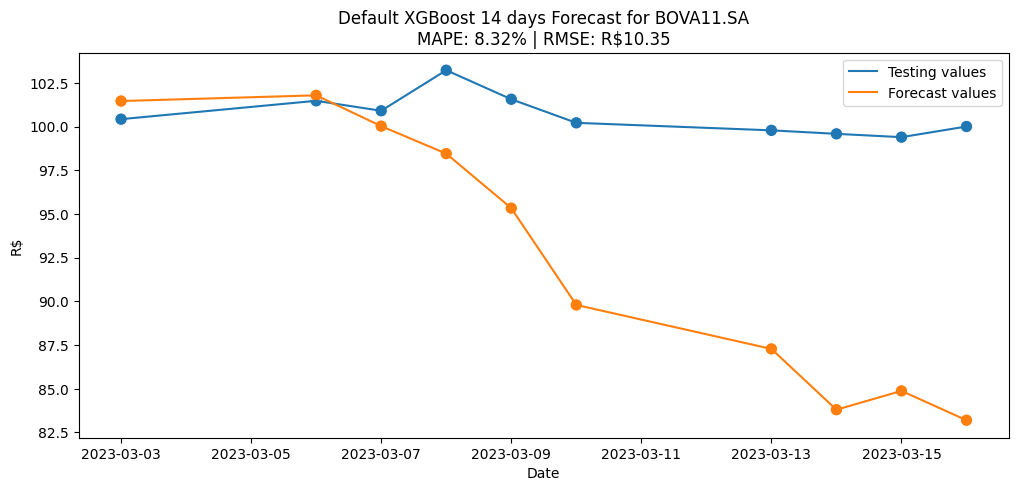

In [51]:
# Execute the whole pipeline
predictions_df = validade_model_one_shot(pd.concat([X_train, X_test], axis=0), pd.concat([y_train, y_test], axis=0), model_config['FORECAST_HORIZON'])

In [52]:
X_test

,Date,day_of_month,month,quarter,Close_lag_1
786,2023-02-27,27.0,2.0,1.0,102.379997
787,2023-02-28,28.0,2.0,1.0,102.290001
788,2023-03-01,1.0,3.0,1.0,101.150002
789,2023-03-02,2.0,3.0,1.0,101.199997
790,2023-03-03,3.0,3.0,1.0,99.940002
791,2023-03-06,6.0,3.0,1.0,100.419998
792,2023-03-07,7.0,3.0,1.0,101.470001
793,2023-03-08,8.0,3.0,1.0,100.900002
794,2023-03-09,9.0,3.0,1.0,103.220001
795,2023-03-10,10.0,3.0,1.0,101.559998


#### 4.2 Stepwise forecasting
Nesta metodologia o modelo é retreinado a cada dia que se passa, utilizando o dia anterior previsto como treinamento

In [ ]:
# Load the raw dataset
stock_df = pd.read_csv('../data/raw/raw_stock_prices.csv', parse_dates=["Date"])

# Perform featurization
features_list = ["day_of_month", "month", "quarter", "Close_lag_1"]

stock_df_feat = build_features(stock_df, features_list)

# train test split
X_train, X_test, y_train, y_test = ts_train_test_split(stock_df_feat, model_config["TARGET_NAME"], model_config["FORECAST_HORIZON"])

# Execute the whole pipeline
predictions_df = validate_model(pd.concat([X_train, X_test], axis=0), pd.concat([y_train, y_test], axis=0), model_config['FORECAST_HORIZON'])

## 5.0 Validando 